In [202]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [203]:
# import os
# import torch
# from PIL import Image, UnidentifiedImageError
# from torchvision import transforms
# 
# # Define the directory containing the dataset
# dataset_dir = "data"
# 
# # Define brightness threshold for image removal
# brightness_threshold = 200
# 
# # Initialize a dictionary to store the count of removed images for each folder
# removed_counts = {}
# 
# # Loop through each class directory in the dataset
# for class_name in os.listdir(dataset_dir):
#     class_dir = os.path.join(dataset_dir, class_name)
#     if os.path.isdir(class_dir):
#         removed_counts[class_name] = 0
#         # Loop through each image file in the class directory
#         for file_name in os.listdir(class_dir):
#             file_path = os.path.join(class_dir, file_name)
#             if os.path.isfile(file_path):
#                 try:
#                     # Open the image
#                     with Image.open(file_path) as img:
#                         # Calculate brightness
#                         grayscale_img = img.convert("L")
#                         brightness = sum(grayscale_img.getdata()) / (grayscale_img.size[0] * grayscale_img.size[1])
#                         # Check brightness threshold
#                         if brightness > brightness_threshold:
#                             os.remove(file_path)
#                             removed_counts[class_name] += 1
#                 except (UnidentifiedImageError, OSError):
#                     print(f"Skipping {file_path} due to UnidentifiedImageError or OSError")
#                     os.remove(file_path)
# 
# # Print the count of removed images for each folder
# for class_name, count in removed_counts.items():
#     print(f"Removed {count} bright images from folder {class_name}")


In [204]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [205]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)

In [206]:
# for param in model.parameters():
#     param.requires_grad = False

In [207]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [208]:
dataset = torchvision.datasets.ImageFolder(root="data", transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [209]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.last_channel, len(dataset.classes))
)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [212]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [213]:
for epoch in range(num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(epoch_accuracy_train)
    
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    epoch_accuracy_val = 100 * correct_val / total_val
    val_accuracies.append(epoch_accuracy_val)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy_train:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy_val:.2f}%')


Epoch [1/10], Train Loss: 1.3663, Train Accuracy: 31.14%, Val Loss: 1.3571, Val Accuracy: 31.18%
Epoch [2/10], Train Loss: 1.3405, Train Accuracy: 37.16%, Val Loss: 1.3308, Val Accuracy: 39.33%
Epoch [3/10], Train Loss: 1.3287, Train Accuracy: 39.28%, Val Loss: 1.3165, Val Accuracy: 44.36%
Epoch [4/10], Train Loss: 1.3098, Train Accuracy: 43.83%, Val Loss: 1.3013, Val Accuracy: 48.92%
Epoch [5/10], Train Loss: 1.2896, Train Accuracy: 48.14%, Val Loss: 1.2727, Val Accuracy: 56.83%
Epoch [6/10], Train Loss: 1.2751, Train Accuracy: 51.80%, Val Loss: 1.2670, Val Accuracy: 55.88%
Epoch [7/10], Train Loss: 1.2518, Train Accuracy: 55.18%, Val Loss: 1.2425, Val Accuracy: 62.11%
Epoch [8/10], Train Loss: 1.2408, Train Accuracy: 57.51%, Val Loss: 1.2245, Val Accuracy: 65.23%
Epoch [9/10], Train Loss: 1.2191, Train Accuracy: 61.95%, Val Loss: 1.2085, Val Accuracy: 68.82%
Epoch [10/10], Train Loss: 1.2022, Train Accuracy: 64.91%, Val Loss: 1.1899, Val Accuracy: 69.78%


In [214]:
test_correct = 0
test_total = 0
true_labels = []
predicted_labels = []
features = []
b_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        batch_features = model.features(inputs).cpu().numpy()
        features.append(batch_features)
        b_labels.append(labels.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 73.51%


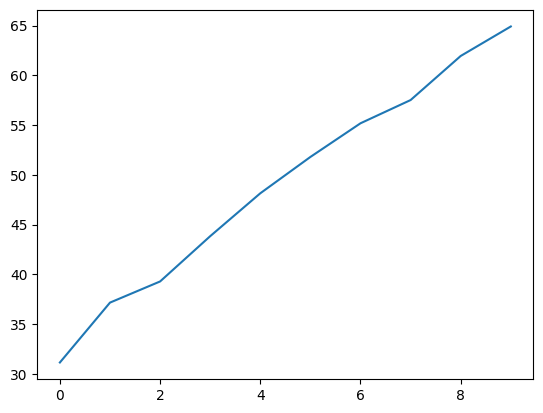

In [215]:
plt.plot(train_accuracies)

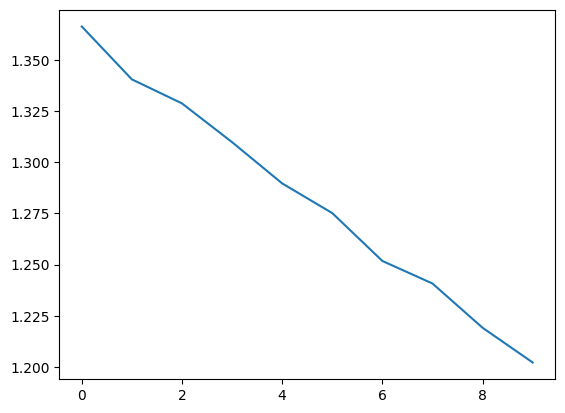

In [216]:
plt.plot(train_losses)

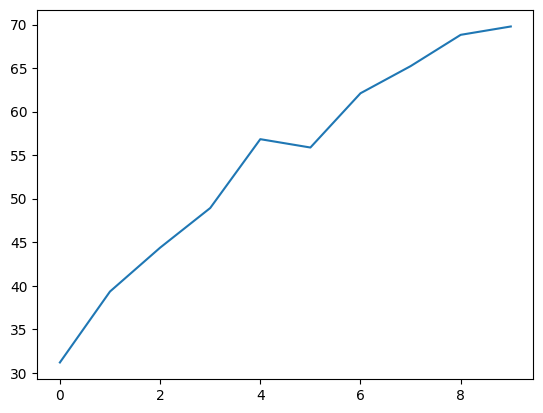

In [217]:
plt.plot(val_accuracies)

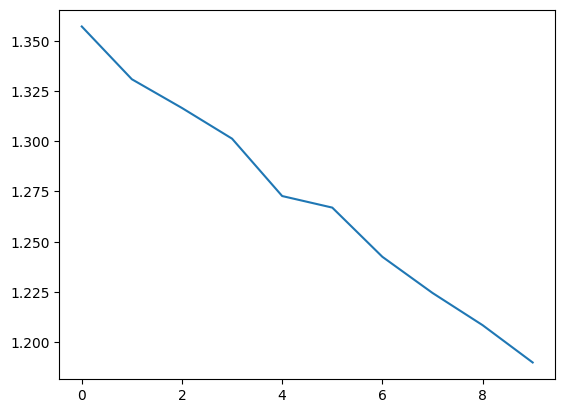

In [218]:
plt.plot(val_losses)

In [219]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)

[[ 68   2  31  12]
 [  2  88  15  22]
 [ 19   0  30   6]
 [  1   0   1 122]]


In [220]:

class_names = [x for x in dataset.classes]

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(class_report)

                precision    recall  f1-score   support

        Blight       0.76      0.60      0.67       113
   Common_Rust       0.98      0.69      0.81       127
Gray_Leaf_Spot       0.39      0.55      0.45        55
       Healthy       0.75      0.98      0.85       124

      accuracy                           0.74       419
     macro avg       0.72      0.71      0.70       419
  weighted avg       0.77      0.74      0.74       419


C:\Users\dared\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dared\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


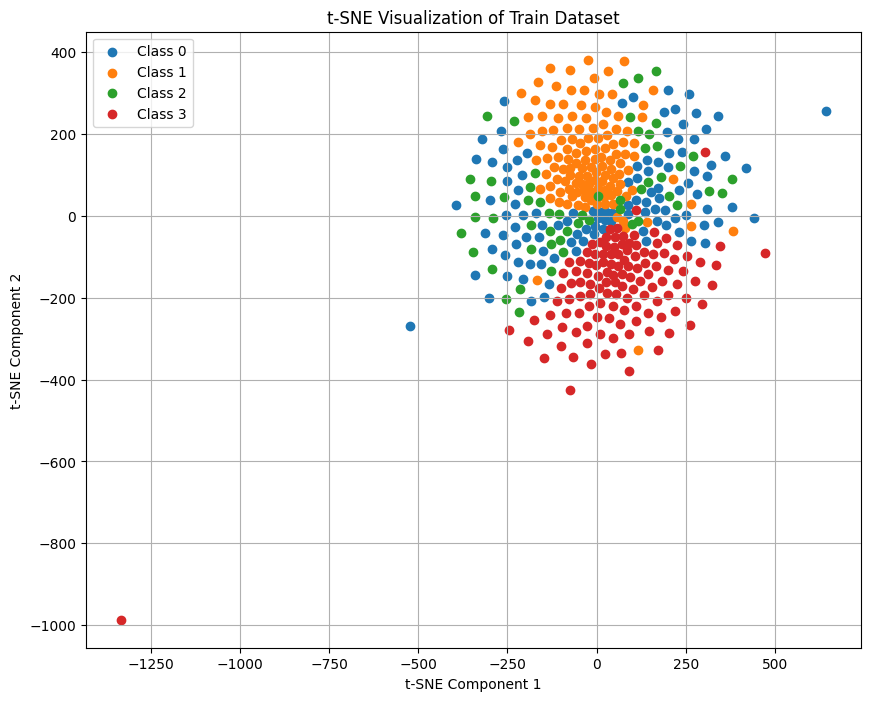

In [221]:
from sklearn.manifold import TSNE

train_features, train_labels = np.vstack(features), np.concatenate(b_labels)
train_features = train_features.reshape(train_features.shape[0], -1)

tsne = TSNE(n_components=2, random_state=42)
train_embeddings = tsne.fit_transform(train_features)

# Plot t-SNE graph
plt.figure(figsize=(10, 8))
for i in range(len(dataset.classes)):
    plt.scatter(train_embeddings[train_labels == i, 0], train_embeddings[train_labels == i, 1], label=f'Class {i}')
plt.title('t-SNE Visualization of Train Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()